In [105]:
#imports
from glob import glob
from os import path
import numpy as np
from halotools.sim_manager import CachedHaloCatalog, RockstarHlistReader, UserSuppliedPtclCatalog
from helpers.readGadgetSnapshot import readGadgetSnapshot
from AbundanceMatching import *
from astropy.cosmology import Planck15

In [106]:
#definitions for creation of catalog
simname = 'chinchilla'
Lbox = 400
npart = 2048
z = 0.2
a = 1/(1+z)
halo_finder = 'rockstar'
pmass = 1.44390e+08*((Lbox / 125.0) ** 3) * ((1024.0/npart)** 3)
version_name = 'Lb400-2048'

In [107]:
#manually create halo catalog
from astropy.table import Table
path_to_cache_local = '/Users/kipac-slac-loaner/Git/desiDeltaSigma/hlist_0.83.list.chinchilla_Lb400-2048.hdf5'
t = Table.read(path_to_cache_local,  format='hdf5')
from halotools.sim_manager import UserSuppliedHaloCatalog
d = dict(zip(t.colnames, (t[n] for n in t.colnames)))
halo_catalog = UserSuppliedHaloCatalog(redshift=z, Lbox=Lbox, particle_mass=pmass, **d)
halo_cache_fname = './halo_cache.hdf5'
halocat = halo_catalog

In [ ]:
#calculate two point galaxy clustering
galaxy_magnitudes = np.genfromtxt('gama_matched_catalog.npy')
downsample_idxs = np.genfromtxt('gama_matched_catalog_idxs.npy')
downsample_idxs = downsample_idxs.astype(int)
#do the downsampling 
galaxy_magnitudes = galaxy_magnitudes[downsample_idxs]
magnitude_cut = galaxy_magnitudes < -19

In [136]:

x = halocat.halo_table['halo_x'][downsample_idxs][magnitude_cut]*0.7
y = halocat.halo_table['halo_y'][downsample_idxs][magnitude_cut]*0.7
z = halocat.halo_table['halo_z'][downsample_idxs][magnitude_cut]*0.7

from halotools.mock_observables import return_xyz_formatted_array, tpcf
import numpy as np
pos=return_xyz_formatted_array(x, y, z)
#rbins=np.logspace(-1, 1.25, 15) #change to bins from sean
binedges   = np.loadtxt('/Users/kipac-slac-loaner/Git/desiDeltaSigma/binfile')
rbins      = np.zeros(len(binedges)+1)
rbins[:-1] = binedges[:,0]
rbins[-1]  = binedges[-1,1]
rbin_centers = (rbins[1:] + rbins[:-1])/2.
xi_all=tpcf(pos, rbins, period=halocat.Lbox*0.7, num_threads='max')

In [132]:
halocat.Lbox

array([ 400.,  400.,  400.])

In [124]:
Planck15.H(0)/100

<Quantity 0.6773999999999998 km / (Mpc s)>

In [121]:
pos

array([[  93.74456787,  114.76196289,  356.83901978],
       [  93.47570038,  115.70175934,  356.78915405],
       [ 187.06297302,  168.60211182,  217.13090515],
       ..., 
       [ 138.35105896,  105.69011688,  256.23590088],
       [ 531.3449707 ,  113.44490051,  446.61480713],
       [ 221.86425781,  120.83715057,  413.35928345]], dtype=float32)

In [109]:
#decomposition into 1-halo and 2-halo terms
from halotools.mock_observables import tpcf_one_two_halo_decomp 
halo_hostid=halocat.halo_table['halo_hostid'][downsample_idxs][magnitude_cut]

xi_1h, xi_2h = tpcf_one_two_halo_decomp(pos,
                halo_hostid, rbins, 
                period = halocat.Lbox,
                num_threads='max')

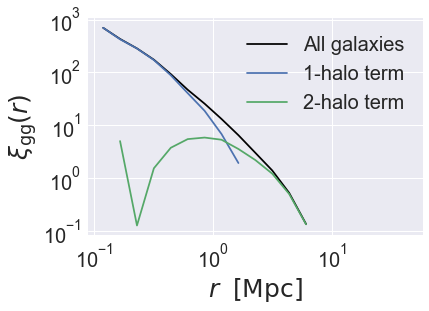

In [110]:
#lets plot the results! 
from seaborn import plt

plt.plot(rbin_centers, xi_all,
         label='All galaxies', color='k')
plt.plot(rbin_centers, xi_1h,
         label = '1-halo term')
plt.plot(rbin_centers, xi_2h,
         label = '2-halo term')

#plt.xlim(xmin = 0.1, xmax = 10)
#plt.ylim(ymin = 1, ymax = 1e3)
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\xi_{\rm gg}(r)$', fontsize=25)
plt.legend(loc='best', fontsize=20)

plt.show()

#mat_clust=np.load(filename)
#bias=gal_clus/matter(xi_all)


In [111]:
#number density
table=halocat.halo_table[downsample_idxs][magnitude_cut]
num_dens=len(table)/Lbox**3
print(num_dens)

0.00074634375


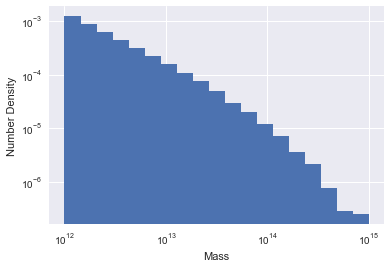

In [112]:
#mass number density
from matplotlib import pyplot as plt
from __future__ import division
%matplotlib inline
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number Density')
plt.xlabel('Mass')
halo_mass=halocat.halo_table['halo_mvir']
plt.hist(halo_mass, bins=np.logspace(12,15,20), weights=np.ones(len(halo_mass))/Lbox**3);

In [113]:
#matter clustering
xi_mm = np.loadtxt('xi_ch400_92_medRes.npy', delimiter=',')
xi_m=xi_mm[:,3]
print(xi_all)
print(xi_m)

[  6.97235527e+02   4.29034563e+02   2.84079376e+02   1.73796437e+02
   9.28150724e+01   4.68972284e+01   2.55654513e+01   1.31321206e+01
   6.47516977e+00   3.00803659e+00   1.39326979e+00   5.24621086e-01
   1.35114155e-01  -1.20689650e-01  -2.65100518e-01  -3.67095565e-01
  -4.29524783e-01  -4.70028137e-01  -5.03815149e-01]
[  2.82648560e+02   1.87237152e+02   1.19691269e+02   7.31605911e+01
   4.25091133e+01   2.32483139e+01   1.19420557e+01   5.86836338e+00
   2.91325474e+00   1.57302713e+00   9.31498408e-01   5.64875603e-01
   3.42031002e-01   1.95021987e-01   1.09310627e-01   5.79545498e-02
   2.79442072e-02   1.09969378e-02   3.41403484e-03]


/Users/kipac-slac-loaner/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


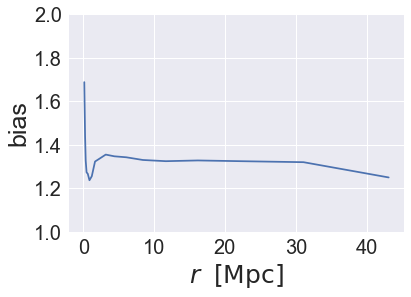

[ 1.68822154  1.58152927  1.44027524  1.3273722   1.2735458   1.26676871
  1.23706481  1.25557602  1.3231474   1.33636828  1.35508697  1.34719304
  1.34269852  1.33029486  1.32477283  1.32812237  1.3246379   1.32017176
  1.24997376]


In [147]:
#BIAS TIME!!
bias=np.sqrt(xi_all/xi_m)
plt.plot(rbin_centers, bias)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('linear')
plt.yscale('linear')
#plt.xlim(xmin = 0.1, xmax = 10)
plt.ylim(ymin = 1, ymax = 2)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel('bias', fontsize=25)
plt.legend(loc='best', fontsize=20)

plt.show()
print(np.sqrt(xi_all/xi_m))

[ 2.85009198  2.50123482  2.07439277  1.76191695  1.62191891  1.60470297
  1.53032935  1.57647114  1.75071903  1.78588018  1.8362607   1.81492909
  1.80283931  1.7696844   1.75502305  1.76390902  1.75466556  1.74285347
  1.56243439]


/Users/kipac-slac-loaner/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


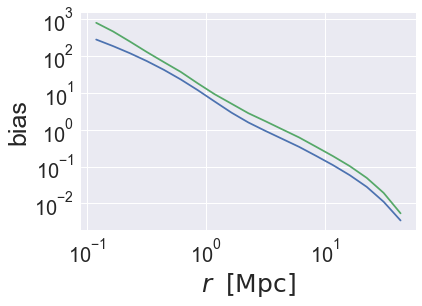

In [141]:
bias=xi_all/xi_m
print(bias)
plt.plot(rbin_centers, xi_m)
plt.plot(rbin_centers, xi_all)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('log')
plt.yscale('log')
#plt.xlim(xmin = 0.1, xmax = 10)
#plt.ylim(ymin = 1, ymax = 10)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel('bias', fontsize=25)
plt.legend(loc='best', fontsize=20)

plt.show()